# Algorithm OMR

OMR is used to match student roll on final exam scripts.<br />
Scripts are scanned using a document scanner and the cover pages are extracted for OMR

# Steps

1- Read Template From input and read Image input

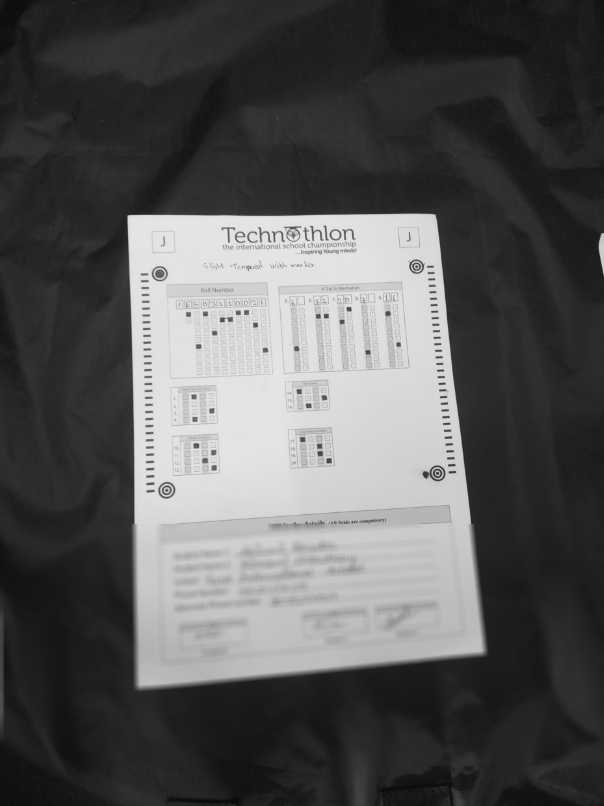

In [1]:
import cv2
from IPython.display import display
from PIL import Image
image =cv2.imread("samples/sample1/MobileCamera/sheet1.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, None, fx = 0.65, fy = 0.65)
display(Image.fromarray(image))

2- Check in tempale to preprocessing <br />
  croppage if input from Mobile <br />
    1-Find page <br />
    2-crop page

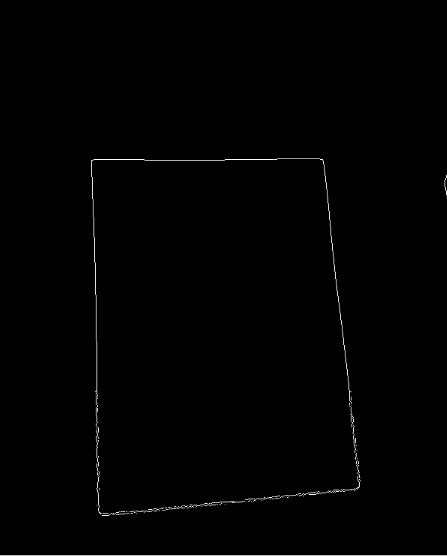

In [3]:
image =cv2.imread("findpagecrop.png", cv2.IMREAD_GRAYSCALE)
display(Image.fromarray(image))

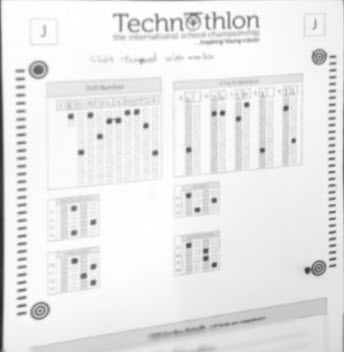

In [4]:
image =cv2.imread("imagwaftercrop-mobile.jpg", cv2.IMREAD_GRAYSCALE)
display(Image.fromarray(image))

2- Crop Maker this step is used if mobile or scanar

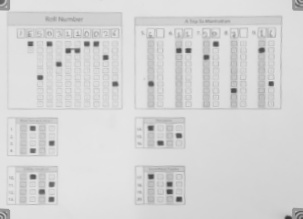

In [6]:
image =cv2.imread("imageaftercropmaker.jpg", cv2.IMREAD_GRAYSCALE)
display(Image.fromarray(image))

Final step Read Response 

In [ ]:
document_scanner =cv2.imread("document_scanner.gif", cv2.IMREAD_GRAYSCALE)
finalimage=cv2.imread("finalimage.jpg", cv2.IMREAD_GRAYSCALE)
display(Image.fromarray(document_scanner))
display(Image.fromarray(finalimage))

# Definitons And Constant

In [21]:
import cv2
import sys
import numpy as np
from IPython.display import display
from PIL import Image
from src.logger import logger
import myclass as my
from matplotlib import pyplot as plt
MIN_PAGE_AREA=8000
min_matching_threshold =  0.3
max_matching_variation = 0.41
apply_erode_subtract =  1

# preprocessing

# 1-     Find paper And Crop

Find page is function used to find point of page and return in Sheet

In [15]:
def find_page( image):  
        image = my.normalize(image)
        _ret, image = cv2.threshold(image, 200, 255, cv2.THRESH_TRUNC)
        image =my.normalize(image)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 10))
        closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        edge = cv2.Canny(closed, 185, 55)
        cnts = my.grab_contours(
            cv2.findContours(edge, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        )
        cnts = [cv2.convexHull(c) for c in cnts]
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
        sheet = []
        for c in cnts:
            if cv2.contourArea(c) < MIN_PAGE_AREA:
                continue
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, epsilon=0.025 * peri, closed=True)
            if True:
                sheet = np.reshape(approx, (4, -1))
                cv2.drawContours(image, [approx], -1, (0,255, 0), 2)
                cv2.drawContours(edge, [approx], -1, (255, 255, 255), 10)
                break
        return sheet


Function Crop page input image and retrun image after crop and find paper in image

In [16]:
def Croppage(image):
        image = my.normalize(cv2.GaussianBlur(image, (3, 3), 0))
        # Resize should be done with another preprocessor is needed
        sheet = find_page(image)
        display("Sheet that Content the point of image is:")
        display(sheet)
        display()
        if sheet == []:
            logger.error(
                "\tError: Paper boundary not found! \
                Have you accidentally included CropPage preprocessor?"
            )
            return None
        # cv2.waitKey(0)
        # Warp layer 1
        image = my.four_point_transform(image, sheet)
        

        # Return preprocessed image
        return image


# input func crop page

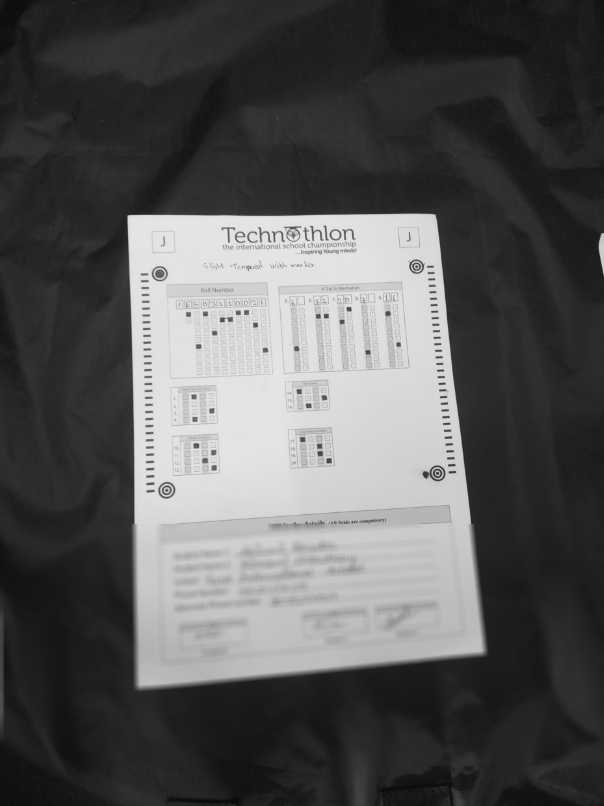

In [17]:
image =cv2.imread("samples/sample1/MobileCamera/sheet1.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, None, fx = 0.65, fy = 0.65)
display(Image.fromarray(image))

# Output retrun Func 

'Sheet that Content the point of image is:'

array([[474, 565],
       [132, 525],
       [127, 216],
       [435, 215]], dtype=int32)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


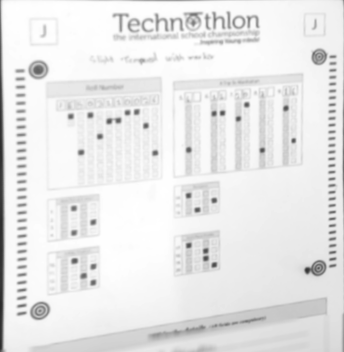

In [18]:
display(Image.fromarray(Croppage( image)))

# 2- Crop based Maker

1-Read MakersSteps of Function of crop:<br />
1-Quad image to four origin to facilitate process Match Template<br />
2-Get bestmatch scale from fuction getbestmatch if you went details about it can view file getbestmatch<br />
3-get optimal markar based scale that returned from gestbest match<br />
4-matching template in each origin in four quade<br />
5-append each Point of center of each quade and draw rectangle <br />
6- Crop page based  this four point by fuction four_point_transform<br />

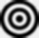

In [22]:
marker = cv2.imread("savedmar.jpeg", cv2.IMREAD_GRAYSCALE)
display(Image.fromarray(marker))

Function find rectangel of page based marker and crop it tage image and marker and return image after crop

In [27]:
def find_page_based_marker(image , marker):
        image_eroded_sub = my.normalize_util(
            image
            if apply_erode_subtract
            else 
            (image - cv2.erode(image, kernel=np.ones((5, 5)), iterations=5))
        )
        # Quads on warped image
        quads = {}
        h1, w1 = image_eroded_sub.shape[:2]
        midh, midw = h1 // 3, w1 // 2
        origins = [[0, 0], [midw, 0], [0, midh], [midw, midh]]
        quads[0] = image_eroded_sub[0:midh, 0:midw]
        quads[1] = image_eroded_sub[0:midh, midw:w1]
        quads[2] = image_eroded_sub[midh:h1, 0:midw]
        quads[3] = image_eroded_sub[midh:h1, midw:w1]

        # Draw Quadlines
        image_eroded_sub[:, midw : midw + 2] = 255
        image_eroded_sub[midh : midh + 2, :] = 255
        # cv2.imshow("e+1",image_eroded_sub)

        best_scale, all_max_t =my.getBestMatch(image_eroded_sub)
        print(all_max_t)
        optimal_marker = my.resize_util_h(
            marker, u_height=int(marker.shape[0] * best_scale)
        )
        _h, w = optimal_marker.shape[:2]
        centres = []
        sum_t, max_t = 0, 0
        logger.info("Matching Marker:\t", end=" ")
        for k in range(0, 4):
            res = cv2.matchTemplate(quads[k], optimal_marker, cv2.TM_CCOEFF_NORMED)
            
            max_t = res.max()
            pt = np.argwhere(res == max_t)[0]
            pt = [pt[1], pt[0]]
            pt[0] += origins[k][0]
            pt[1] += origins[k][1]
            print(">>",pt)
            image = cv2.rectangle(
                image, tuple(pt), (pt[0] + w, pt[1] + _h), (150, 150, 150), 2
            )
            # cv2.imshow(str(k + 5),image)
            # display:
            image_eroded_sub = cv2.rectangle(
                image_eroded_sub,
                tuple(pt),
                (pt[0] + w, pt[1] + _h),
                (50, 50, 50) if apply_erode_subtract else (155, 155, 155),
                4,
            )
            centres.append([pt[0] + w / 2, pt[1] + _h / 2])
            sum_t += max_t
        logger.info("Optimal Scale:", best_scale)
        display(Image.fromarray(image))
        image = my.four_point_transform(image, np.array(centres))
        return image

# Inputs

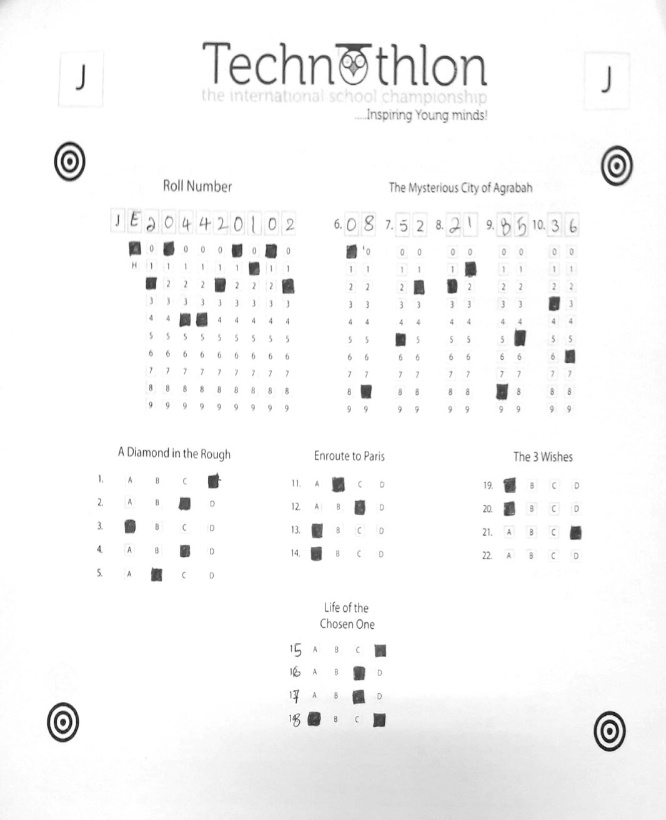

In [25]:
image2 = cv2.imread("savedimage.jpeg", cv2.IMREAD_GRAYSCALE)
display(Image.fromarray(image2 ))

# Outputs

0.591402


[11:14:06] INFO     Matching Marker:                                                                   ]8;id=369815;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=745568;file:///home/jovyan/src/logger.py#50\50]8;;\

>> [52, 144]
>> [599, 148]
>> [46, 705]
>> [592, 714]


           INFO     Optimal Scale: 0.94                                                                ]8;id=411622;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=382993;file:///home/jovyan/src/logger.py#50\50]8;;\

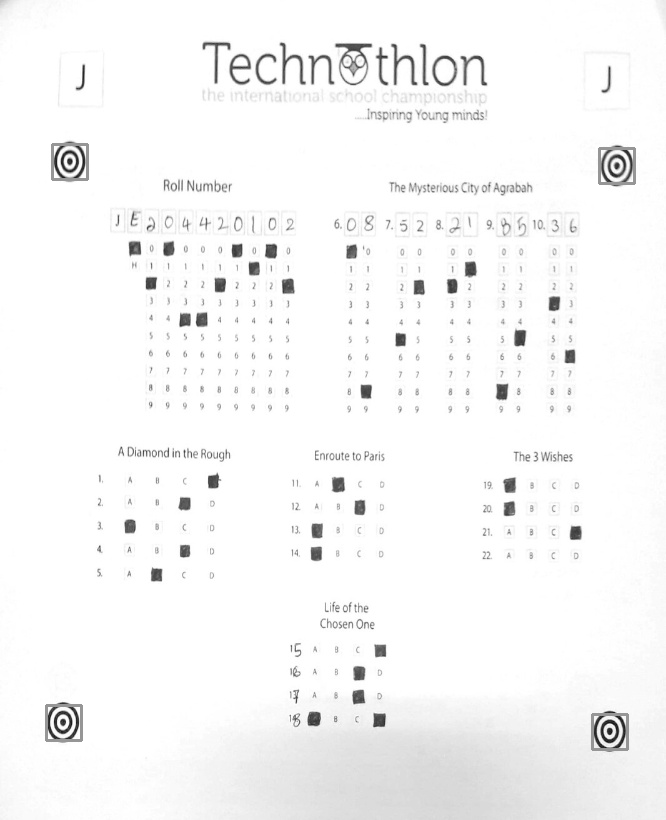

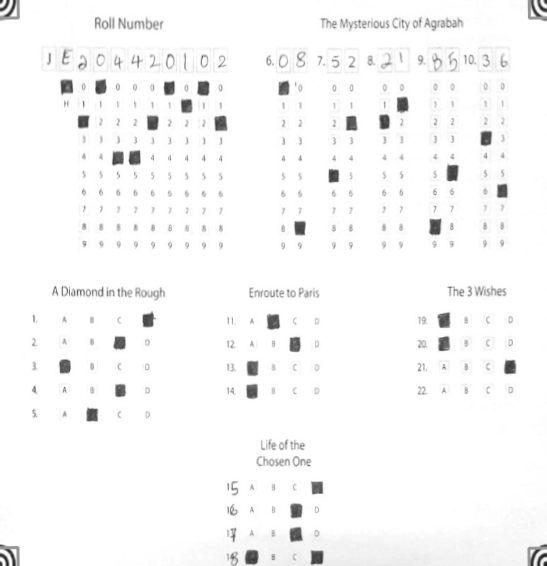

In [28]:
display(Image.fromarray(find_page_based_marker( image , marker)))